In [2]:
import numpy as np
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from pde import MemoryStorage, PDEBase, ScalarField, VectorField, MemoryStorage, CartesianGrid
from pde import solve_laplace_equation, solve_poisson_equation

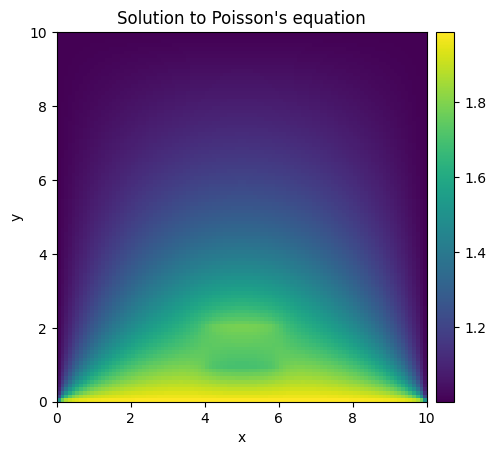

In [64]:


shape = (100, 100)
x_length, y_length = 10, 10 #meters 
grid = CartesianGrid([[0, x_length], [0, y_length]], shape)  

bc = [[{"value": 1}, {"value": 1}], [{"value": 2}, {"value": 1}]]

P = np.ones(shape)

s = np.ones(shape) * 0.1
s[40:60, 10:20] = 0.9

nu1 = 0.1 # cP
nu2 = 1 # cP
k = 100 # mD

F = 1e-6*k*(s/nu1 + (1-s)/nu2)

P_f = solve_laplace_equation(grid=grid, bc=bc)

# P_f = ScalarField(grid, data=P)
F_f = ScalarField(grid, data=F)

rhs = - P_f.gradient(bc='derivative') @ F_f.gradient(bc='derivative') / F_f

res = solve_poisson_equation(rhs, bc=bc)
w = - F_f * res.gradient(bc='derivative')
div_w = w.divergence(bc='derivative')
res.plot()

In [96]:

class One_Phase_Gas_Grav(PDEBase):

    def __init__(self):
        super().__init__()
        self.shape = (100, 100) #, 100) # points
        self.sides = ((0, 10), (0, 10)) #, (0, 10)) # meters
        self.k = 100 # mD
        self.m = 0.5
        self.ro1 = 1 * 1e3 # начальная плотность kg/m3
        # self.ro2 = 1
        self.nu1 = 0.01 # вязкость cP
        # self.nu2 = 1
        self.p0 = 0.1 # MPa press
        eps = 1e-8

        # generate grid
        self.grid = CartesianGrid(self.sides, self.shape)  

        # k scalar field
        self.k_field = ScalarField(self.grid, data=self.k)

        # initial state
        self.p_ini_field = ScalarField(self.grid, data=self.ro1) # MPa
        # self.p2_ini_field = ScalarField(self.grid, data=0.1)
        # self.s_field = ScalarField(self.grid, data=eps) # ini saturartion
        
        g = np.zeros((2,) + self.shape) # 3 for 3d
        g[1,:] = - 9.81 * 1e-6 # 2 for 3d  to be good with pressire in MPa
        self.g_field = VectorField(self.grid, data=g) # grav field

        # boundary condition
        # self.bc_p1 = [{'derivative':0}, {'derivative':0}, [{'value': 0.1}, {'value': 1}]] # for 3d
        # self.bc_p1 = [{'derivative':0}, [{'value': 1}, {'value': 0.1}]]
        self.bc_p1 = [{'derivative':0}, {'derivative':0}]


        # self.bc_p2 = [{'derivative'}, {'derivative'}, [{'value': 0.1},{'value': 0.1}]]
        # self.bc_s = [{'derivative'}, {'derivative'}, [{'value': 1-eps},{'value': eps}]]

    # def k1(s):
    #     return s
    
    # def k2(s):
    #     return s

    def P(self, ro):
        p = ro * self.p0 / self.ro1
        return p
    
    def ro(self, p):
        ro = p * self.ro1 / self.p0
        return ro
    
    def evolution_rate(self, P, t=0):
        ''' Basniev pp.256'''
        ro = self.ro(P)
        a = 1e-6 * self.k/self.nu1 # const, 1e-6 to be good with pressure in MPa
        g = self.g_field
        w1 = - a * (P.gradient({'derivative':0}) - ro * g)
 
        dro_dt = - (1/self.m) * (ro * w1).divergence({'value':0}) # zero mass flow at bounds
        dP_dt = self.P(dro_dt)

        return dP_dt

In [97]:
eq = One_Phase_Gas_Grav()

p0 = eq.p_ini_field
storage = MemoryStorage()
res = eq.solve(p0, t_range=20000, adaptive=True, tracker=['progress', 'plot', storage.tracker(1)])

  0%|          | 0/20000.0 [00:00<?, ?it/s]

Output()